In [1]:
import numpy as np # linear algebra
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score,mean_squared_error


Задача регрессии - датасет про автомобили и их стоимость

In [2]:
df = pd.read_csv("https://raw.githubusercontent.com/evgpat/edu_stepik_practical_ml/main/datasets/cars_prices.csv", decimal='.')

In [3]:
df

,symboling,normalized-losses,make,fuel-type,aspiration,num-of-doors,body-style,drive-wheels,engine-location,wheel-base,...,engine-size,fuel-system,bore,stroke,compression-ratio,horsepower,peak-rpm,city-mpg,highway-mpg,price
0,3,?,alfa-romero,gas,std,two,convertible,rwd,front,88.6,...,130,mpfi,3.47,2.68,9.0,111,5000,21,27,13495
1,3,?,alfa-romero,gas,std,two,convertible,rwd,front,88.6,...,130,mpfi,3.47,2.68,9.0,111,5000,21,27,16500
2,1,?,alfa-romero,gas,std,two,hatchback,rwd,front,94.5,...,152,mpfi,2.68,3.47,9.0,154,5000,19,26,16500
3,2,164,audi,gas,std,four,sedan,fwd,front,99.8,...,109,mpfi,3.19,3.40,10.0,102,5500,24,30,13950
4,2,164,audi,gas,std,four,sedan,4wd,front,99.4,...,136,mpfi,3.19,3.40,8.0,115,5500,18,22,17450
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
200,-1,95,volvo,gas,std,four,sedan,rwd,front,109.1,...,141,mpfi,3.78,3.15,9.5,114,5400,23,28,16845
201,-1,95,volvo,gas,turbo,four,sedan,rwd,front,109.1,...,141,mpfi,3.78,3.15,8.7,160,5300,19,25,19045
202,-1,95,volvo,gas,std,four,sedan,rwd,front,109.1,...,173,mpfi,3.58,2.87,8.8,134,5500,18,23,21485
203,-1,95,volvo,diesel,turbo,four,sedan,rwd,front,109.1,...,145,idi,3.01,3.40,23.0,106,4800,26,27,22470


In [3]:
# Описание некоторых признаков

# symboling - rating corresponds to the degree to which the auto is more risky than its price indicates (+3 more risk and -3 is pretty safe)
# make - car types (i.e. car brand)
# fuel-type - types of fuel (gas or diesel)
# aspiration - engine aspiration (standard or turbo)
# num-of-doors - numbers of doors (two or four)
# body-style - car body style (sedan or hachback)
# drive-wheels - which types of drive wheel (forward-fwd, reversed-rwd)
# engine-location - engine mounted location (front or back)
# wheel-base - расстояние между осями передних и задних колес
# length - car lenght
# weight - car weight
# width - car width
# height - car height

In [3]:
# Заполним пропуски (Здесь они обозначены ?)

for c in df.columns:
    print(c, len(df[df[c] == '?']))

symboling 0
normalized-losses 41
make 0
fuel-type 0
aspiration 0
num-of-doors 2
body-style 0
drive-wheels 0
engine-location 0
wheel-base 0
length 0
width 0
height 0
curb-weight 0
engine-type 0
num-of-cylinders 0
engine-size 0
fuel-system 0
bore 4
stroke 4
compression-ratio 0
horsepower 2
peak-rpm 2
city-mpg 0
highway-mpg 0
price 4


In [4]:
# Удалим строки где неизвестно значение target - price

df = df[df['price'] != '?']

for c in df.columns:
    print(c, len(df[df[c] == '?']))

symboling 0
normalized-losses 37
make 0
fuel-type 0
aspiration 0
num-of-doors 2
body-style 0
drive-wheels 0
engine-location 0
wheel-base 0
length 0
width 0
height 0
curb-weight 0
engine-type 0
num-of-cylinders 0
engine-size 0
fuel-system 0
bore 4
stroke 4
compression-ratio 0
horsepower 2
peak-rpm 2
city-mpg 0
highway-mpg 0
price 0


In [5]:
# Взяли категории
categ_cols = df.select_dtypes(exclude='number').columns.to_list()

# Заполним числовые признаки средним
numeric_cols = df.select_dtypes(include='number').columns.to_list()
df[numeric_cols] = df[numeric_cols].fillna(df[numeric_cols].mean())


# Вставим в категор-ый - самое частое значение

df['num-of-doors'] = df['num-of-doors'].replace('?', 'four')
df['num-of-doors'].describe()

,num-of-doors
count,201
unique,2
top,four
freq,115


In [6]:
# Заменим ? на None
cols_with_replace = ['bore', 'stroke', 'horsepower', 'peak-rpm']

df[cols_with_replace] = df[cols_with_replace].replace('?', None)


# Заполним средним и переводим в числовой тип

df[cols_with_replace] = df[cols_with_replace][df[cols_with_replace].isnull() == False].astype('float64')

df[cols_with_replace] = df[cols_with_replace].fillna(df[cols_with_replace].mean())


In [7]:
# Пропуски в столбце normalized-losses предскажем при помощи линейной регрессии по признакам symboling, wheel-base,
# length, width, height, curb-weight, engine-size, compression-ratio, city-mpg, highway-mpg и заполним их предсказаниями

from sklearn.linear_model import LinearRegression

df['normalized-losses'].replace('?', None, inplace=True)
df['normalized-losses'] = df['normalized-losses'][df['normalized-losses'].isnull() == False].astype('int64')


df_new = df.copy()
df_new = df_new.loc[:, ['normalized-losses','symboling', 'wheel-base', 'length', 'width', 'height', 'curb-weight', 'engine-size', 'compression-ratio', 'city-mpg', 'highway-mpg']]

train_nl = df_new[df_new['normalized-losses'].isnull() == False]
test_nl = df_new[df_new['normalized-losses'].isnull() == True]
y = train_nl['normalized-losses']
train_nl = train_nl.drop(['normalized-losses'], axis=1)
test_nl = test_nl.drop(['normalized-losses'], axis=1)


lr = LinearRegression()
lr.fit(train_nl, y)
predict_empty = lr.predict(test_nl)
predict_empty

<ipython-input-7-fd2624334c3c>:6: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['normalized-losses'].replace('?', None, inplace=True)


array([168.07249262, 168.07249262, 134.0017988 , 150.03347669,
       124.36459916, 136.54127678, 127.28771126, 138.09039231,
       130.51306948, 113.6478041 , 155.82813541, 175.60424066,
       166.04457052,  88.0845543 , 122.53305095, 127.5822689 ,
       161.54047049, 154.33123955, 132.97923436, 178.13829126,
       179.87212963, 179.97064318, 131.27495017, 119.95762868,
       144.30448909, 121.04127767, 177.84275063, 157.63816248,
       157.63816248, 158.50508167,  98.29098277, 154.71344201,
       121.38477454, 137.06488059, 108.12442301,  94.62530543,
       106.22799742])

In [8]:
df_2 = df.copy()
indices = test_nl.index.to_list()
df_2.loc[indices, 'normalized-losses'] = predict_empty
df_2


,symboling,normalized-losses,make,fuel-type,aspiration,num-of-doors,body-style,drive-wheels,engine-location,wheel-base,...,engine-size,fuel-system,bore,stroke,compression-ratio,horsepower,peak-rpm,city-mpg,highway-mpg,price
0,3,168.072493,alfa-romero,gas,std,two,convertible,rwd,front,88.6,...,130,mpfi,3.47,2.68,9.0,111.0,5000.0,21,27,13495
1,3,168.072493,alfa-romero,gas,std,two,convertible,rwd,front,88.6,...,130,mpfi,3.47,2.68,9.0,111.0,5000.0,21,27,16500
2,1,134.001799,alfa-romero,gas,std,two,hatchback,rwd,front,94.5,...,152,mpfi,2.68,3.47,9.0,154.0,5000.0,19,26,16500
3,2,164.000000,audi,gas,std,four,sedan,fwd,front,99.8,...,109,mpfi,3.19,3.40,10.0,102.0,5500.0,24,30,13950
4,2,164.000000,audi,gas,std,four,sedan,4wd,front,99.4,...,136,mpfi,3.19,3.40,8.0,115.0,5500.0,18,22,17450
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
200,-1,95.000000,volvo,gas,std,four,sedan,rwd,front,109.1,...,141,mpfi,3.78,3.15,9.5,114.0,5400.0,23,28,16845
201,-1,95.000000,volvo,gas,turbo,four,sedan,rwd,front,109.1,...,141,mpfi,3.78,3.15,8.7,160.0,5300.0,19,25,19045
202,-1,95.000000,volvo,gas,std,four,sedan,rwd,front,109.1,...,173,mpfi,3.58,2.87,8.8,134.0,5500.0,18,23,21485
203,-1,95.000000,volvo,diesel,turbo,four,sedan,rwd,front,109.1,...,145,idi,3.01,3.40,23.0,106.0,4800.0,26,27,22470


In [9]:
# Закодируем бинарные признаки fuel-type, aspiration, num-of-doors, engine-location каждый отдельной колонкой, состоящей из 0 и 1.

binary = ['fuel-type', 'aspiration', 'num-of-doors', 'engine-location']

df_2['fuel-type'] = df_2['fuel-type'].map({'gas':1, 'diesel':0})
df_2['aspiration'] = df_2['aspiration'].map({'std':1, 'turbo':0})
df_2['num-of-doors'] = df_2['num-of-doors'].map({'four':1, 'two':0})
df_2['engine-location'] = df_2['engine-location'].map({'front':1, 'rear':0})


In [10]:
X = df_2.drop(['price'], axis=1)
y = df_2['price']

In [ ]:
# Закодируем признаки make, body-style, engine-type, fuel-system при помощи LeaveOneOutEncoder.

In [11]:
!pip install category_encoders -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 82.0/82.0 kB 4.8 MB/s eta 0:00:00


In [12]:
X['normalized-losses'] = X['normalized-losses'].astype(float)
X['bore'] = X['bore'].astype(float)
X['stroke'] = X['stroke'].astype(float)
X['horsepower'] = X['horsepower'].astype(float)
X['peak-rpm'] = X['peak-rpm'].astype(float)

y = y.astype(float)

In [13]:
import pandas as pd
from category_encoders.leave_one_out import LeaveOneOutEncoder


# Применение LeaveOneOutEncoder
looe = LeaveOneOutEncoder(cols=['make', 'body-style', 'engine-type', 'fuel-system'])
X_enc = looe.fit_transform(X, y)



In [14]:
from category_encoders.one_hot import OneHotEncoder

OHE = OneHotEncoder(cols=['drive-wheels'])
X_ohc_enc = OHE.fit_transform(X_enc)
X_ohc_enc

,symboling,normalized-losses,make,fuel-type,aspiration,num-of-doors,body-style,drive-wheels_1,drive-wheels_2,drive-wheels_3,...,num-of-cylinders,engine-size,fuel-system,bore,stroke,compression-ratio,horsepower,peak-rpm,city-mpg,highway-mpg
0,3,168.072493,16500.0,1,1,0,23569.600000,1,0,0,...,four,130,17650.307692,3.47,2.68,9.0,111.0,5000.0,21,27
1,3,168.072493,14997.5,1,1,0,22968.600000,1,0,0,...,four,130,17617.285714,3.47,2.68,9.0,111.0,5000.0,21,27
2,1,134.001799,14997.5,1,1,0,9859.791045,1,0,0,...,six,152,17617.285714,2.68,3.47,9.0,154.0,5000.0,19,26
3,2,164.000000,18641.0,1,1,1,14465.236559,0,1,0,...,four,109,17645.307692,3.19,3.40,10.0,102.0,5500.0,24,30
4,2,164.000000,17941.0,1,1,1,14427.602151,0,0,1,...,five,136,17606.846154,3.19,3.40,8.0,115.0,5500.0,18,22
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
200,-1,95.000000,18185.0,1,1,1,14434.107527,1,0,0,...,four,141,17613.494505,3.78,3.15,9.5,114.0,5400.0,23,28
201,-1,95.000000,17965.0,1,0,1,14410.451613,1,0,0,...,four,141,17589.318681,3.78,3.15,8.7,160.0,5300.0,19,25
202,-1,95.000000,17721.0,1,1,1,14384.215054,1,0,0,...,six,173,17562.505495,3.58,2.87,8.8,134.0,5500.0,18,23
203,-1,95.000000,17622.5,0,0,1,14373.623656,1,0,0,...,six,145,15489.105263,3.01,3.40,23.0,106.0,4800.0,26,27


In [15]:
#В столбце num-of-cylinders категории упорядочены по смыслу - OrdinalEncoder

from category_encoders.ordinal import OrdinalEncoder

oren = OrdinalEncoder(cols=['num-of-cylinders'])
X_or_ohe_looe = oren.fit_transform(X_ohc_enc)
X_or_ohe_looe



,symboling,normalized-losses,make,fuel-type,aspiration,num-of-doors,body-style,drive-wheels_1,drive-wheels_2,drive-wheels_3,...,num-of-cylinders,engine-size,fuel-system,bore,stroke,compression-ratio,horsepower,peak-rpm,city-mpg,highway-mpg
0,3,168.072493,16500.0,1,1,0,23569.600000,1,0,0,...,1,130,17650.307692,3.47,2.68,9.0,111.0,5000.0,21,27
1,3,168.072493,14997.5,1,1,0,22968.600000,1,0,0,...,1,130,17617.285714,3.47,2.68,9.0,111.0,5000.0,21,27
2,1,134.001799,14997.5,1,1,0,9859.791045,1,0,0,...,2,152,17617.285714,2.68,3.47,9.0,154.0,5000.0,19,26
3,2,164.000000,18641.0,1,1,1,14465.236559,0,1,0,...,1,109,17645.307692,3.19,3.40,10.0,102.0,5500.0,24,30
4,2,164.000000,17941.0,1,1,1,14427.602151,0,0,1,...,3,136,17606.846154,3.19,3.40,8.0,115.0,5500.0,18,22
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
200,-1,95.000000,18185.0,1,1,1,14434.107527,1,0,0,...,1,141,17613.494505,3.78,3.15,9.5,114.0,5400.0,23,28
201,-1,95.000000,17965.0,1,0,1,14410.451613,1,0,0,...,1,141,17589.318681,3.78,3.15,8.7,160.0,5300.0,19,25
202,-1,95.000000,17721.0,1,1,1,14384.215054,1,0,0,...,2,173,17562.505495,3.58,2.87,8.8,134.0,5500.0,18,23
203,-1,95.000000,17622.5,0,0,1,14373.623656,1,0,0,...,2,145,15489.105263,3.01,3.40,23.0,106.0,4800.0,26,27


In [16]:
from sklearn.model_selection import train_test_split

Xtrain, Xtest, ytrain, ytest = train_test_split(X_or_ohe_looe, y, test_size=0.25, random_state=42)

In [17]:
# Нормализуем признаки

from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
Xtrain = scaler.fit_transform(Xtrain)
Xtest = scaler.transform(Xtest)

In [18]:
import torch
import torch.nn as nn

import torch.nn.functional as F


In [19]:
# Сначала переведем в тензор

Xtrain = torch.tensor(Xtrain, dtype = torch.float32)
Xtest = torch.tensor(Xtest, dtype = torch.float32)

ytrain = torch.tensor(ytrain.values, dtype = torch.float32)
ytest = torch.tensor(ytest.values, dtype = torch.float32)

In [20]:
# Создадим кастомный датасет

from torch.utils.data import Dataset, DataLoader

class CustomDataset(Dataset):

  def __init__(self, X, y):

    self.X = X
    self.y = y

  def __len__(self):

    return len(self.X)

  def __getitem__(self, idx):

    return self.X[idx], self.y[idx]


In [21]:
# Сделаем DataLoader - тк данных мало (201 строка) сделаем батч из всех объектов тренировочной и тестовой выборки

train_dataset = CustomDataset(Xtrain, ytrain)
test_dataset = CustomDataset(Xtest, ytest)

train_loader = DataLoader(train_dataset, batch_size=len(train_dataset), shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=len(test_dataset), shuffle=False)




In [22]:
for X, y in train_loader:
  print(X.shape, y.shape)

torch.Size([150, 27]) torch.Size([150])


Будем экспериментировать с архитектурой сети, а также с количеством эпох обучения

1. Сеть с тремя слоями, 2-ой hidden layer имеет одинаковое кол-во input и output

In [23]:
# Создадим архитектуру сети

class Regress_NN(nn.Module):

  def __init__(self, input_size):
    super(Regress_NN, self).__init__()

    # Сделаем 2 hidden layer

    self.fc1 = nn.Sequential(
        nn.Linear(27, 54),
        nn.BatchNorm1d(num_features=54),
        nn.ReLU(inplace = True)
    )

    self.fc2 = nn.Sequential(
        nn.Linear(54, 54),
        nn.BatchNorm1d(num_features=54),
        nn.ReLU(inplace = True)
    )

    self.fc3 = nn.Linear(54, 1)

    self._initialize_weights()

  def forward(self, x):

    out = self.fc1(x)
    out = self.fc2(out)

    return self.fc3(out)

  def _initialize_weights(self):

    for m in self.modules():

      if isinstance(m, nn.Linear):

        nn.init.kaiming_normal_(m.weight, mode='fan_in', nonlinearity='relu')

        if m.bias is not None:

          nn.init.zeros_(m.bias)




In [ ]:
# Будем экспериментировать с архитектурой сети, а также с количеством эпох обучения

In [24]:
import torch
import numpy as np
import random

def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)

    # Если используете DataLoader с shuffle=True, фиксируем seed в DataLoader
    torch.use_deterministic_algorithms(True)  # Детерминированные алгоритмы для PyTorch

# Устанавливаем seed перед началом обучения
set_seed(42)


In [25]:
def train(model, train_loader, optimizer, criterion, num_epochs):

    # Устанавливаем seed перед началом обучения
    set_seed(42)


    train_losses = []
    test_losses = []

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0

        for X_batch, y_batch in train_loader:
            outputs = model(X_batch)
            loss = criterion(outputs.squeeze(), y_batch)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            running_loss += loss.item()  # Добавляем лосс без умножения на размер батча

        epoch_loss = running_loss / len(train_loader)  # Средний лосс за эпоху
        train_losses.append(epoch_loss)

        # if epoch % 100 == 0:
        #   print(f'Epoch: {epoch}, loss: {epoch_loss}')  # Печатаем средний лосс за эпоху

        model.eval()

        test_running_loss = 0.0

        with torch.no_grad():

            for X_batch, y_batch in test_loader:

              preds = model(X_batch)

              loss = criterion(preds.squeeze(), y_batch).item()

              test_running_loss += loss

        test_losses.append(test_running_loss / len(test_loader))


    return train_losses, test_losses


def predict(model, test_loader):

  model.eval()
  predictions = []

  test_losses = 0.0
  with torch.no_grad():

    for X_batch, y_batch in test_loader:

      preds = model(X_batch)

      predictions.append(preds)

      # loss = criterion(preds, y_batch)
      # test_loss += loss.item()



  return predictions
# test_losses.append(test_loss / len(test_loader))




In [26]:
model = Regress_NN(input_size = 27)

criterion = nn.MSELoss()

optimizer = torch.optim.AdamW(model.parameters(), lr = 0.1)


Epochs: 500 | R^2 score: 0.8588873147964478, MSE: 3902.297912768834
Epochs: 700 | R^2 score: 0.7977347373962402, MSE: 4671.948629854571
Epochs: 900 | R^2 score: 0.7468388080596924, MSE: 5226.801316292786
Epochs: 1100 | R^2 score: 0.7805153131484985, MSE: 4866.755592794855
Epochs: 1300 | R^2 score: 0.9066165089607239, MSE: 3174.479484891972
Epochs: 1500 | R^2 score: 0.7939408421516418, MSE: 4715.561260337946
Epochs: 1700 | R^2 score: 0.8331521153450012, MSE: 4243.241685315603
Epochs: 1900 | R^2 score: 0.8708662986755371, MSE: 3732.9935708490043
Epochs: 2100 | R^2 score: 0.917185366153717, MSE: 2989.4482768564503


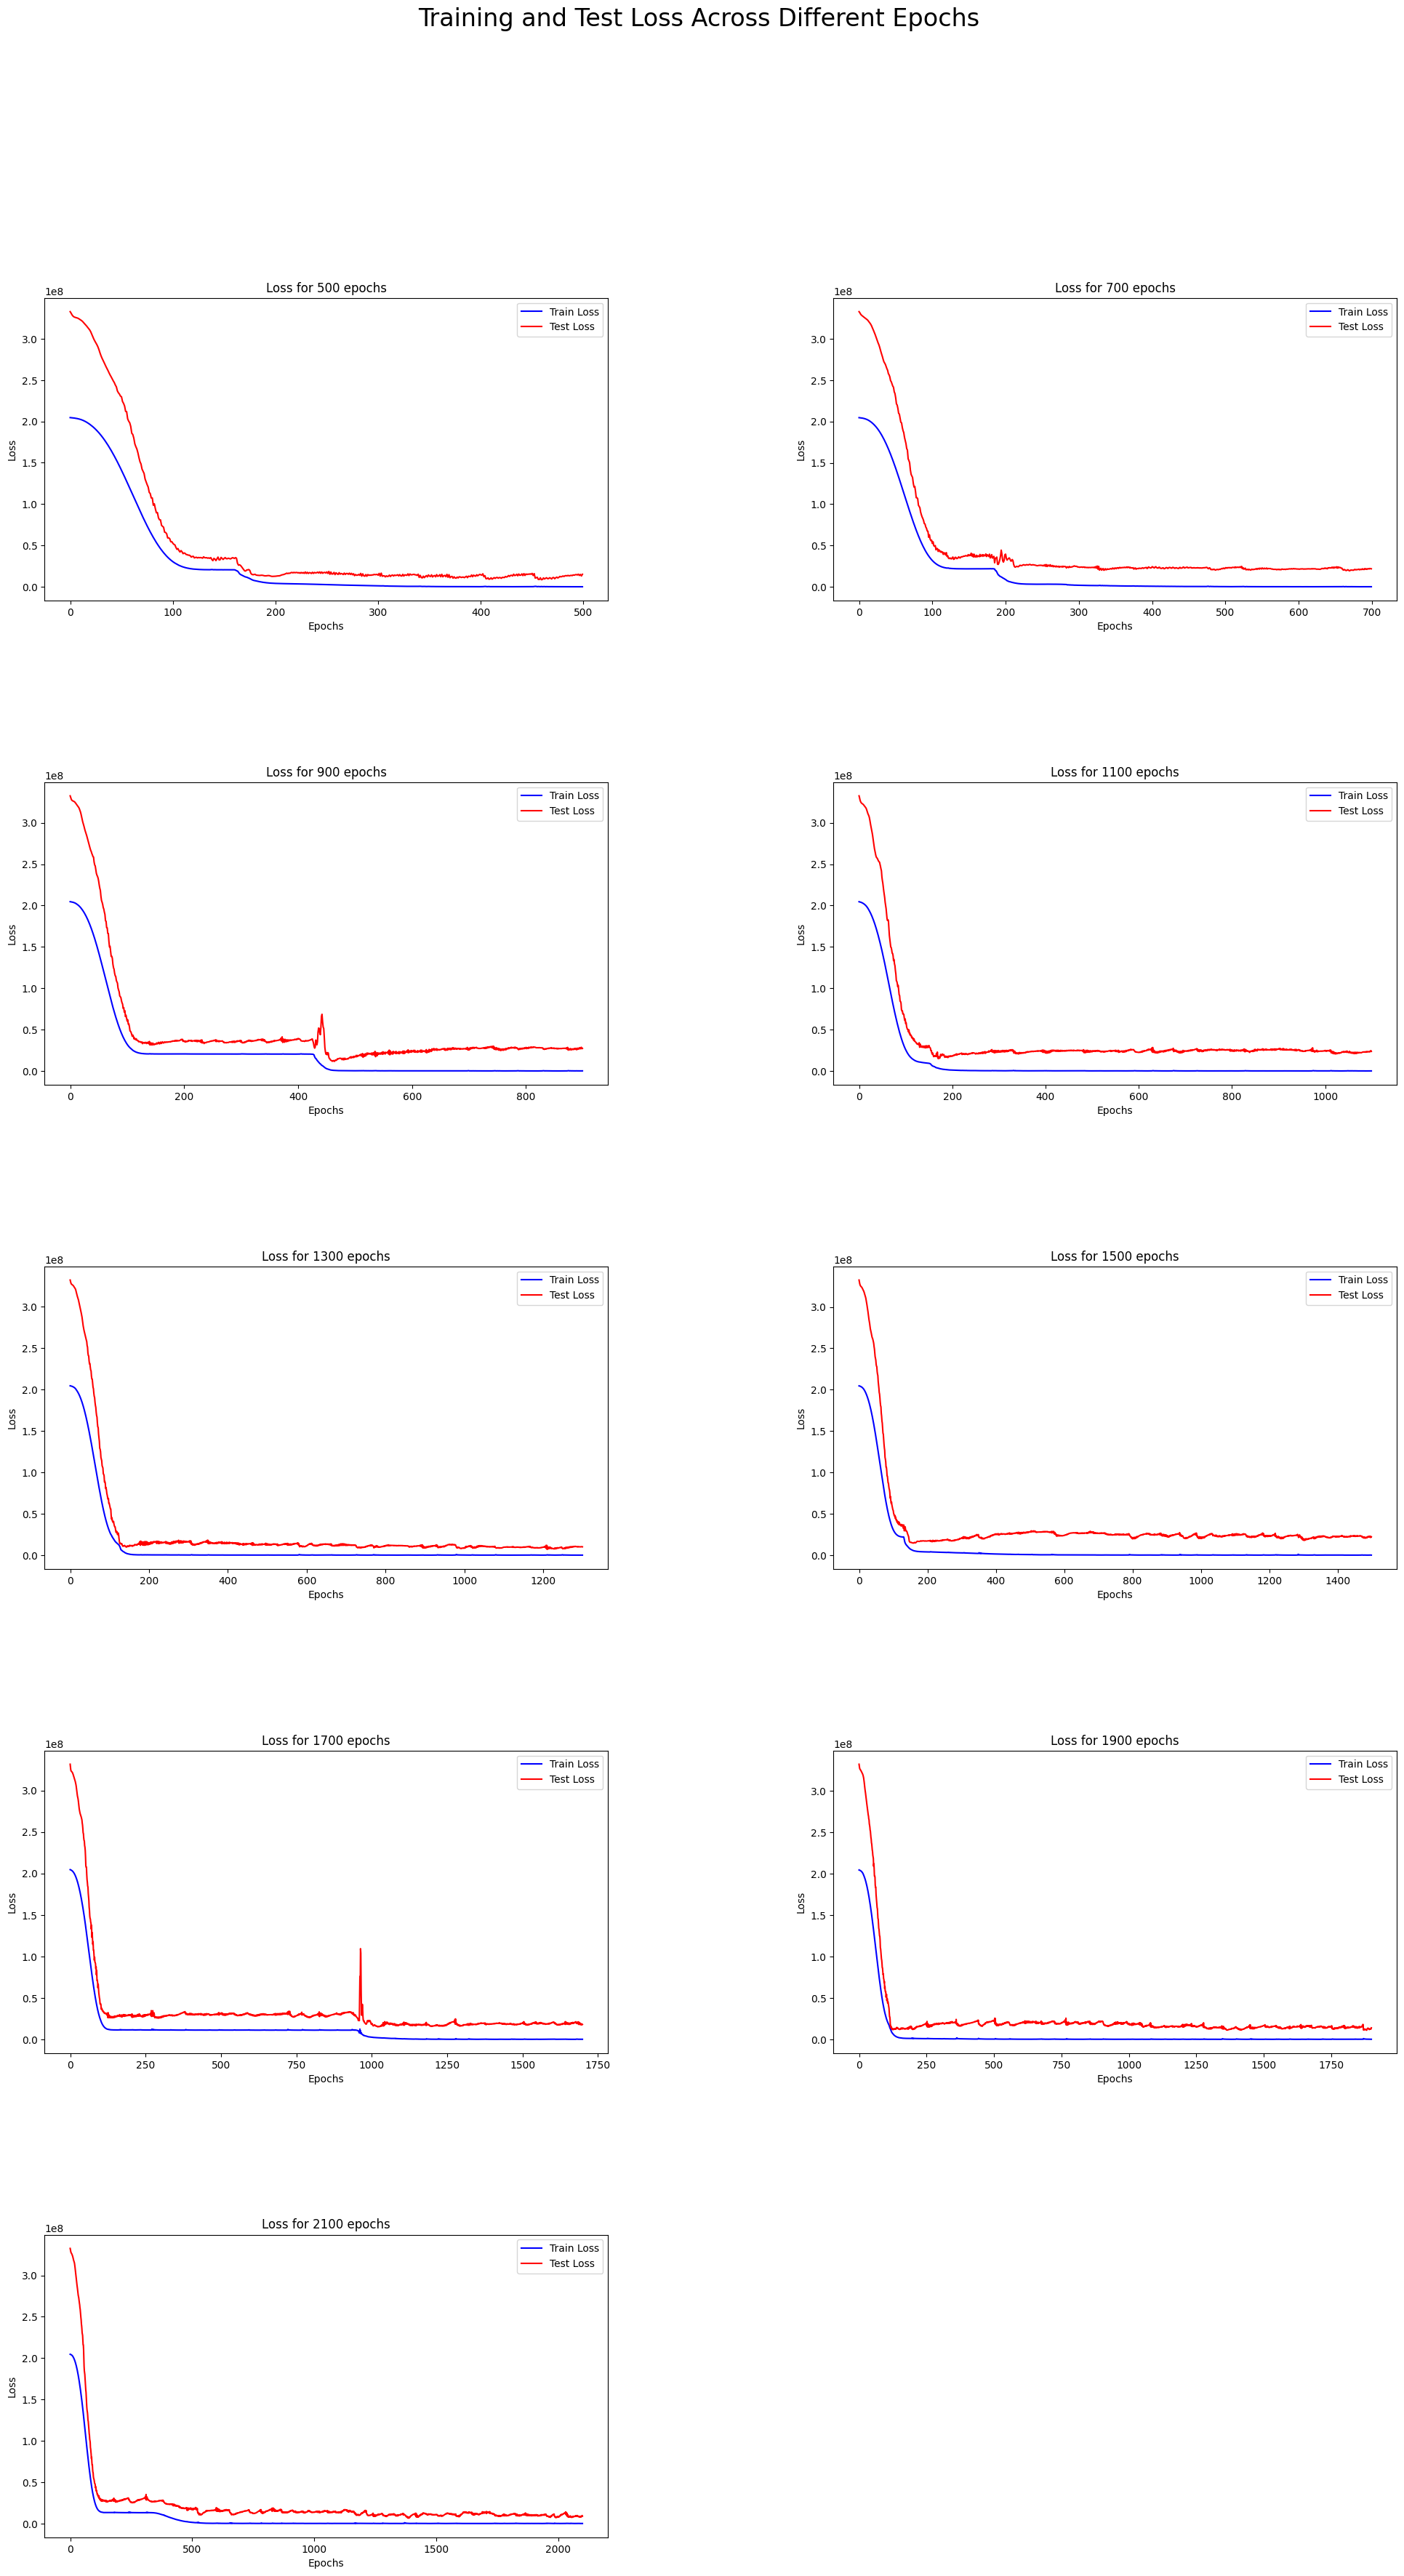

In [31]:
# Будем идти от 500 до 10000 эпох обучения с шагом 500!
# Выводим лосс в трейне и тесте

import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import numpy as np
from sklearn.metrics import r2_score, mean_squared_error

fig = plt.figure(figsize=(24, 40))  # Увеличиваем размер фигуры для размещения 20 графиков
outer_grid = GridSpec(5, 2, figure=fig, wspace=0.4, hspace=0.6)  # 10 строк и 2 столбца для 20 графиков

predictions = []

for i, num_epochs in enumerate(np.arange(500, 2101, 200)):

    # Инициализация модели

    model = Regress_NN(input_size = 27)

    criterion = nn.MSELoss()

    optimizer = torch.optim.AdamW(model.parameters(), lr = 0.1)

    # Тренировка модели и предсказание

    train_loss, test_loss = train(model=model, train_loader=train_loader, optimizer=optimizer, criterion=criterion, num_epochs=num_epochs)
    preds = predict(model, test_loader)

    predictions.append(preds)

    # Вычисляем метрики
    r2 = r2_score(ytest.numpy(), preds[0].numpy())
    mse = mean_squared_error(ytest.numpy(), preds[0].numpy()) ** 0.5
    print(f'Epochs: {num_epochs} | R^2 score: {r2}, MSE: {mse}')

    # Добавляем подграфик на сетку
    ax = fig.add_subplot(outer_grid[i])
    ax.plot(np.arange(0, num_epochs), train_loss, color='b', label='Train Loss')
    ax.plot(np.arange(0, num_epochs), test_loss, color='r', label='Test Loss')

    # Настраиваем легенду и заголовок для каждого подграфика
    ax.legend()
    ax.set_title(f'Loss for {num_epochs} epochs')
    ax.set_xlabel('Epochs')
    ax.set_ylabel('Loss')

# Устанавливаем общий заголовок
plt.suptitle('Training and Test Loss Across Different Epochs', fontsize=24)
plt.show()






По метрике, лучший вариант был с 2100 эпохами. Из этой архитекутры возьмем его

In [29]:
best_preds_v1 = predictions[8]

2. Попробуем теперь 4 полносвязных слоя, оценим качество модели. Также проэкспериментируем с эпохами обучения.

In [32]:
# Создадим архитектуру сети

class Regress_NNv2(nn.Module):

  def __init__(self, input_size):
    super(Regress_NNv2, self).__init__()

    # Сделаем 2 hidden layer

    self.fc1 = nn.Sequential(
        nn.Linear(27, 54),
        nn.BatchNorm1d(num_features=54),
        nn.ReLU(inplace = True)
    )

    self.fc2 = nn.Sequential(
        nn.Linear(54, 54),
        nn.BatchNorm1d(num_features=54),
        nn.ReLU(inplace = True)
    )

    self.fc3 = nn.Sequential(
        nn.Linear(54, 27),
        nn.BatchNorm1d(num_features=27),
        nn.ReLU(inplace = True)
    )

    self.fc4 = nn.Linear(27, 1)

    self._initialize_weights()

  def forward(self, x):

    out = self.fc1(x)
    out = self.fc2(out)
    out = self.fc3(out)

    return self.fc4(out)

  def _initialize_weights(self):

    for m in self.modules():

      if isinstance(m, nn.Linear):

        nn.init.kaiming_normal_(m.weight, mode='fan_in', nonlinearity='relu')

        if m.bias is not None:

          nn.init.zeros_(m.bias)

Epochs: 500 | R^2 score: 0.7784664034843445, MSE: 4889.418779364271
Epochs: 700 | R^2 score: 0.8259953260421753, MSE: 4333.291358771067
Epochs: 900 | R^2 score: 0.8659286499023438, MSE: 3803.6926794892356
Epochs: 1100 | R^2 score: 0.7966024279594421, MSE: 4685.008004262106
Epochs: 1300 | R^2 score: 0.7960087060928345, MSE: 4691.841003273662
Epochs: 1500 | R^2 score: 0.7754634618759155, MSE: 4922.445530424892
Epochs: 1700 | R^2 score: 0.8849104642868042, MSE: 3524.157629845748
Epochs: 1900 | R^2 score: 0.9143622517585754, MSE: 3039.9758222722758
Epochs: 2100 | R^2 score: 0.8306028246879578, MSE: 4275.535522013587


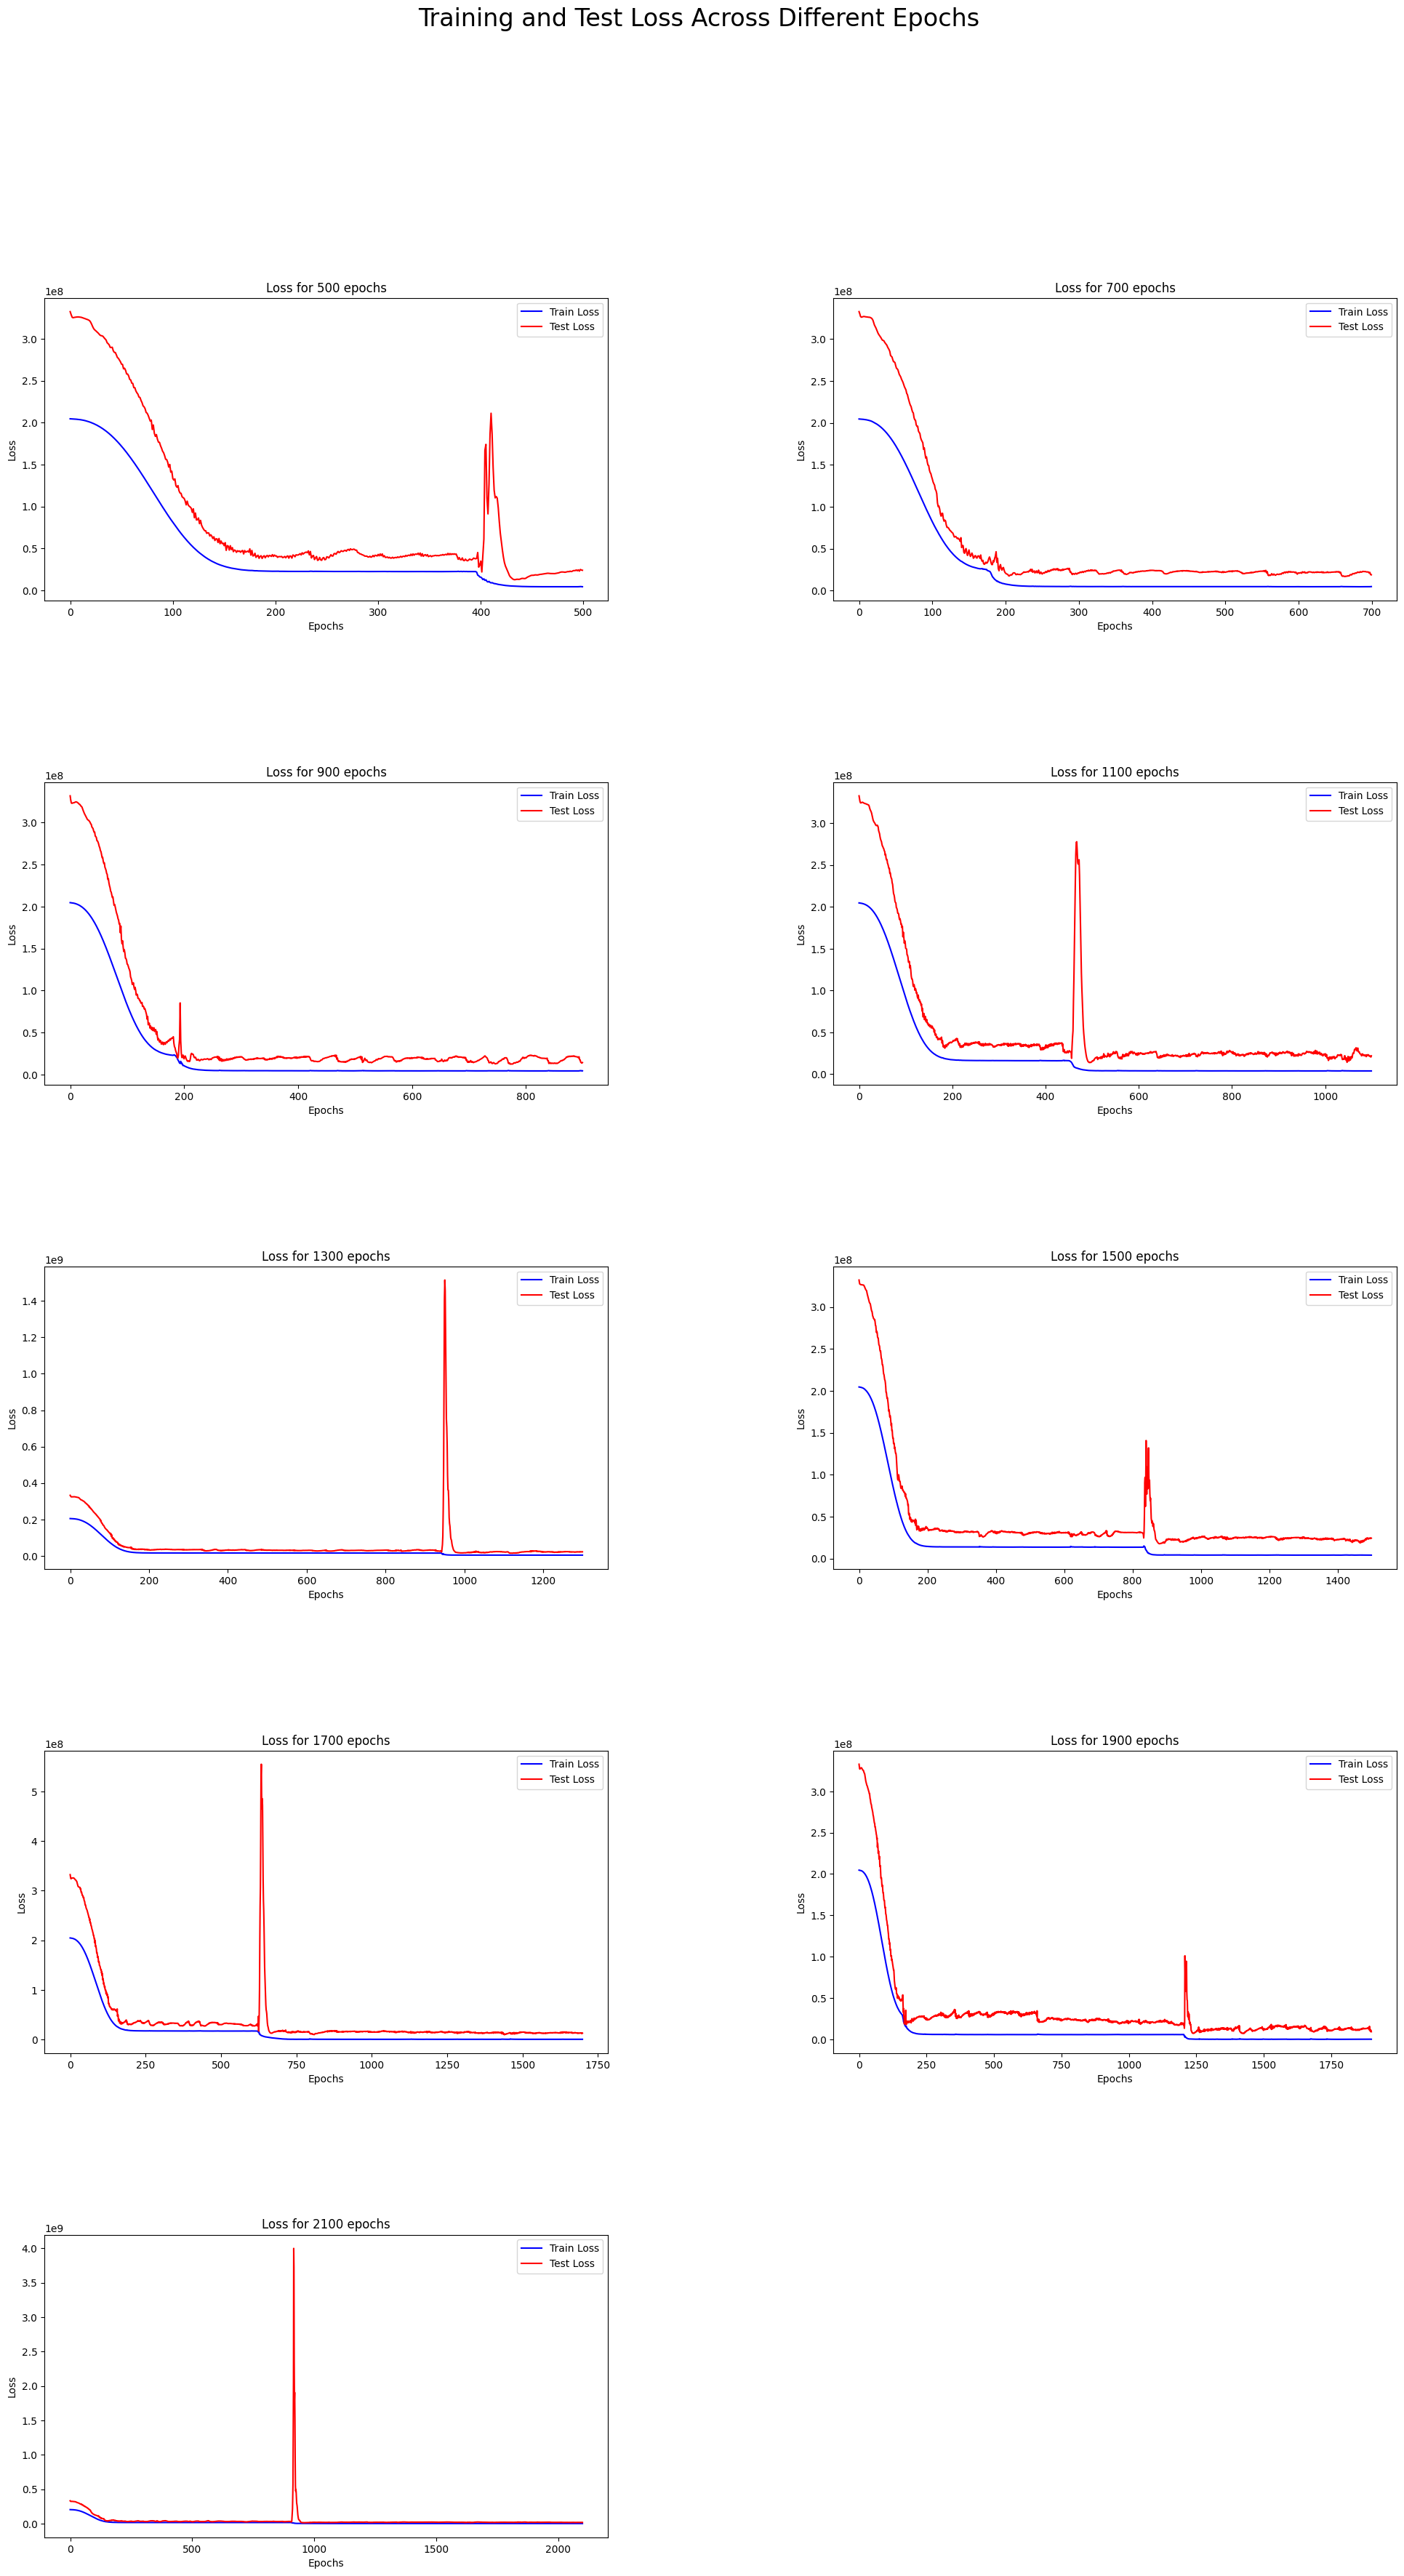

In [35]:
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec


fig = plt.figure(figsize=(24, 40))  # Увеличиваем размер фигуры для размещения 20 графиков
outer_grid = GridSpec(5, 2, figure=fig, wspace=0.4, hspace=0.6)  # 10 строк и 2 столбца для 20 графиков

predictions = []

for i, num_epochs in enumerate(np.arange(500, 2101, 200)):

    # Инициализация модели

    model = Regress_NNv2(input_size = 27)

    criterion = nn.MSELoss()

    optimizer = torch.optim.AdamW(model.parameters(), lr = 0.1)

    # Тренировка модели и предсказание
    train_loss, test_loss = train(model=model, train_loader=train_loader, optimizer=optimizer, criterion=criterion, num_epochs=num_epochs)
    preds = predict(model, test_loader)

    predictions.append(preds)

    # Вычисляем метрики
    r2 = r2_score(ytest.numpy(), preds[0].numpy())
    mse = mean_squared_error(ytest.numpy(), preds[0].numpy()) ** 0.5
    print(f'Epochs: {num_epochs} | R^2 score: {r2}, MSE: {mse}')

    # Добавляем подграфик на сетку
    ax = fig.add_subplot(outer_grid[i])
    ax.plot(np.arange(0, num_epochs), train_loss, color='b', label='Train Loss')
    ax.plot(np.arange(0, num_epochs), test_loss, color='r', label='Test Loss')

    # Настраиваем легенду и заголовок для каждого подграфика
    ax.legend()
    ax.set_title(f'Loss for {num_epochs} epochs')
    ax.set_xlabel('Epochs')
    ax.set_ylabel('Loss')

# Устанавливаем общий заголовок
plt.suptitle('Training and Test Loss Across Different Epochs', fontsize=24)
plt.show()

Видим, что в случае данной архитектуры, модель не может сделать нормальный шаг градиентного спуска в области ступеньки лосс функции. Это можно рещить scheduler, но зачем, когда более простая архитектура не имеет такой проблемы.

3. Так как обучающая выборка мала, можно финально попробовать не усложнять модель, а сделать два полносвязаных слоя (один hidden)

In [36]:
# Создадим архитектуру сети

class Regress_NNv3(nn.Module):

  def __init__(self, input_size):
    super(Regress_NNv3, self).__init__()

    # Сделаем 2 hidden layer

    self.fc1 = nn.Sequential(
        nn.Linear(27, 54),
        nn.BatchNorm1d(num_features=54),
        nn.ReLU(inplace = True)
    )

    self.fc2 = nn.Linear(54, 1)

    self._initialize_weights()

  def forward(self, x):

    out = self.fc1(x)

    return self.fc2(out)

  def _initialize_weights(self):

    for m in self.modules():

      if isinstance(m, nn.Linear):

        nn.init.kaiming_normal_(m.weight, mode='fan_in', nonlinearity='relu')

        if m.bias is not None:

          nn.init.zeros_(m.bias)

Epochs: 500 | R^2 score: 0.9036997556686401, MSE: 3223.674611371315
Epochs: 700 | R^2 score: 0.9077889919281006, MSE: 3154.4875970591484
Epochs: 900 | R^2 score: 0.910894513130188, MSE: 3100.91341381858
Epochs: 1100 | R^2 score: 0.9168922901153564, MSE: 2994.7325423149227
Epochs: 1300 | R^2 score: 0.9129229187965393, MSE: 3065.4153062839628
Epochs: 1500 | R^2 score: 0.924727737903595, MSE: 2850.0663150179507
Epochs: 1700 | R^2 score: 0.9082076549530029, MSE: 3147.3185412347443
Epochs: 1900 | R^2 score: 0.9240860342979431, MSE: 2862.188410989046
Epochs: 2100 | R^2 score: 0.9174882173538208, MSE: 2983.97687658601


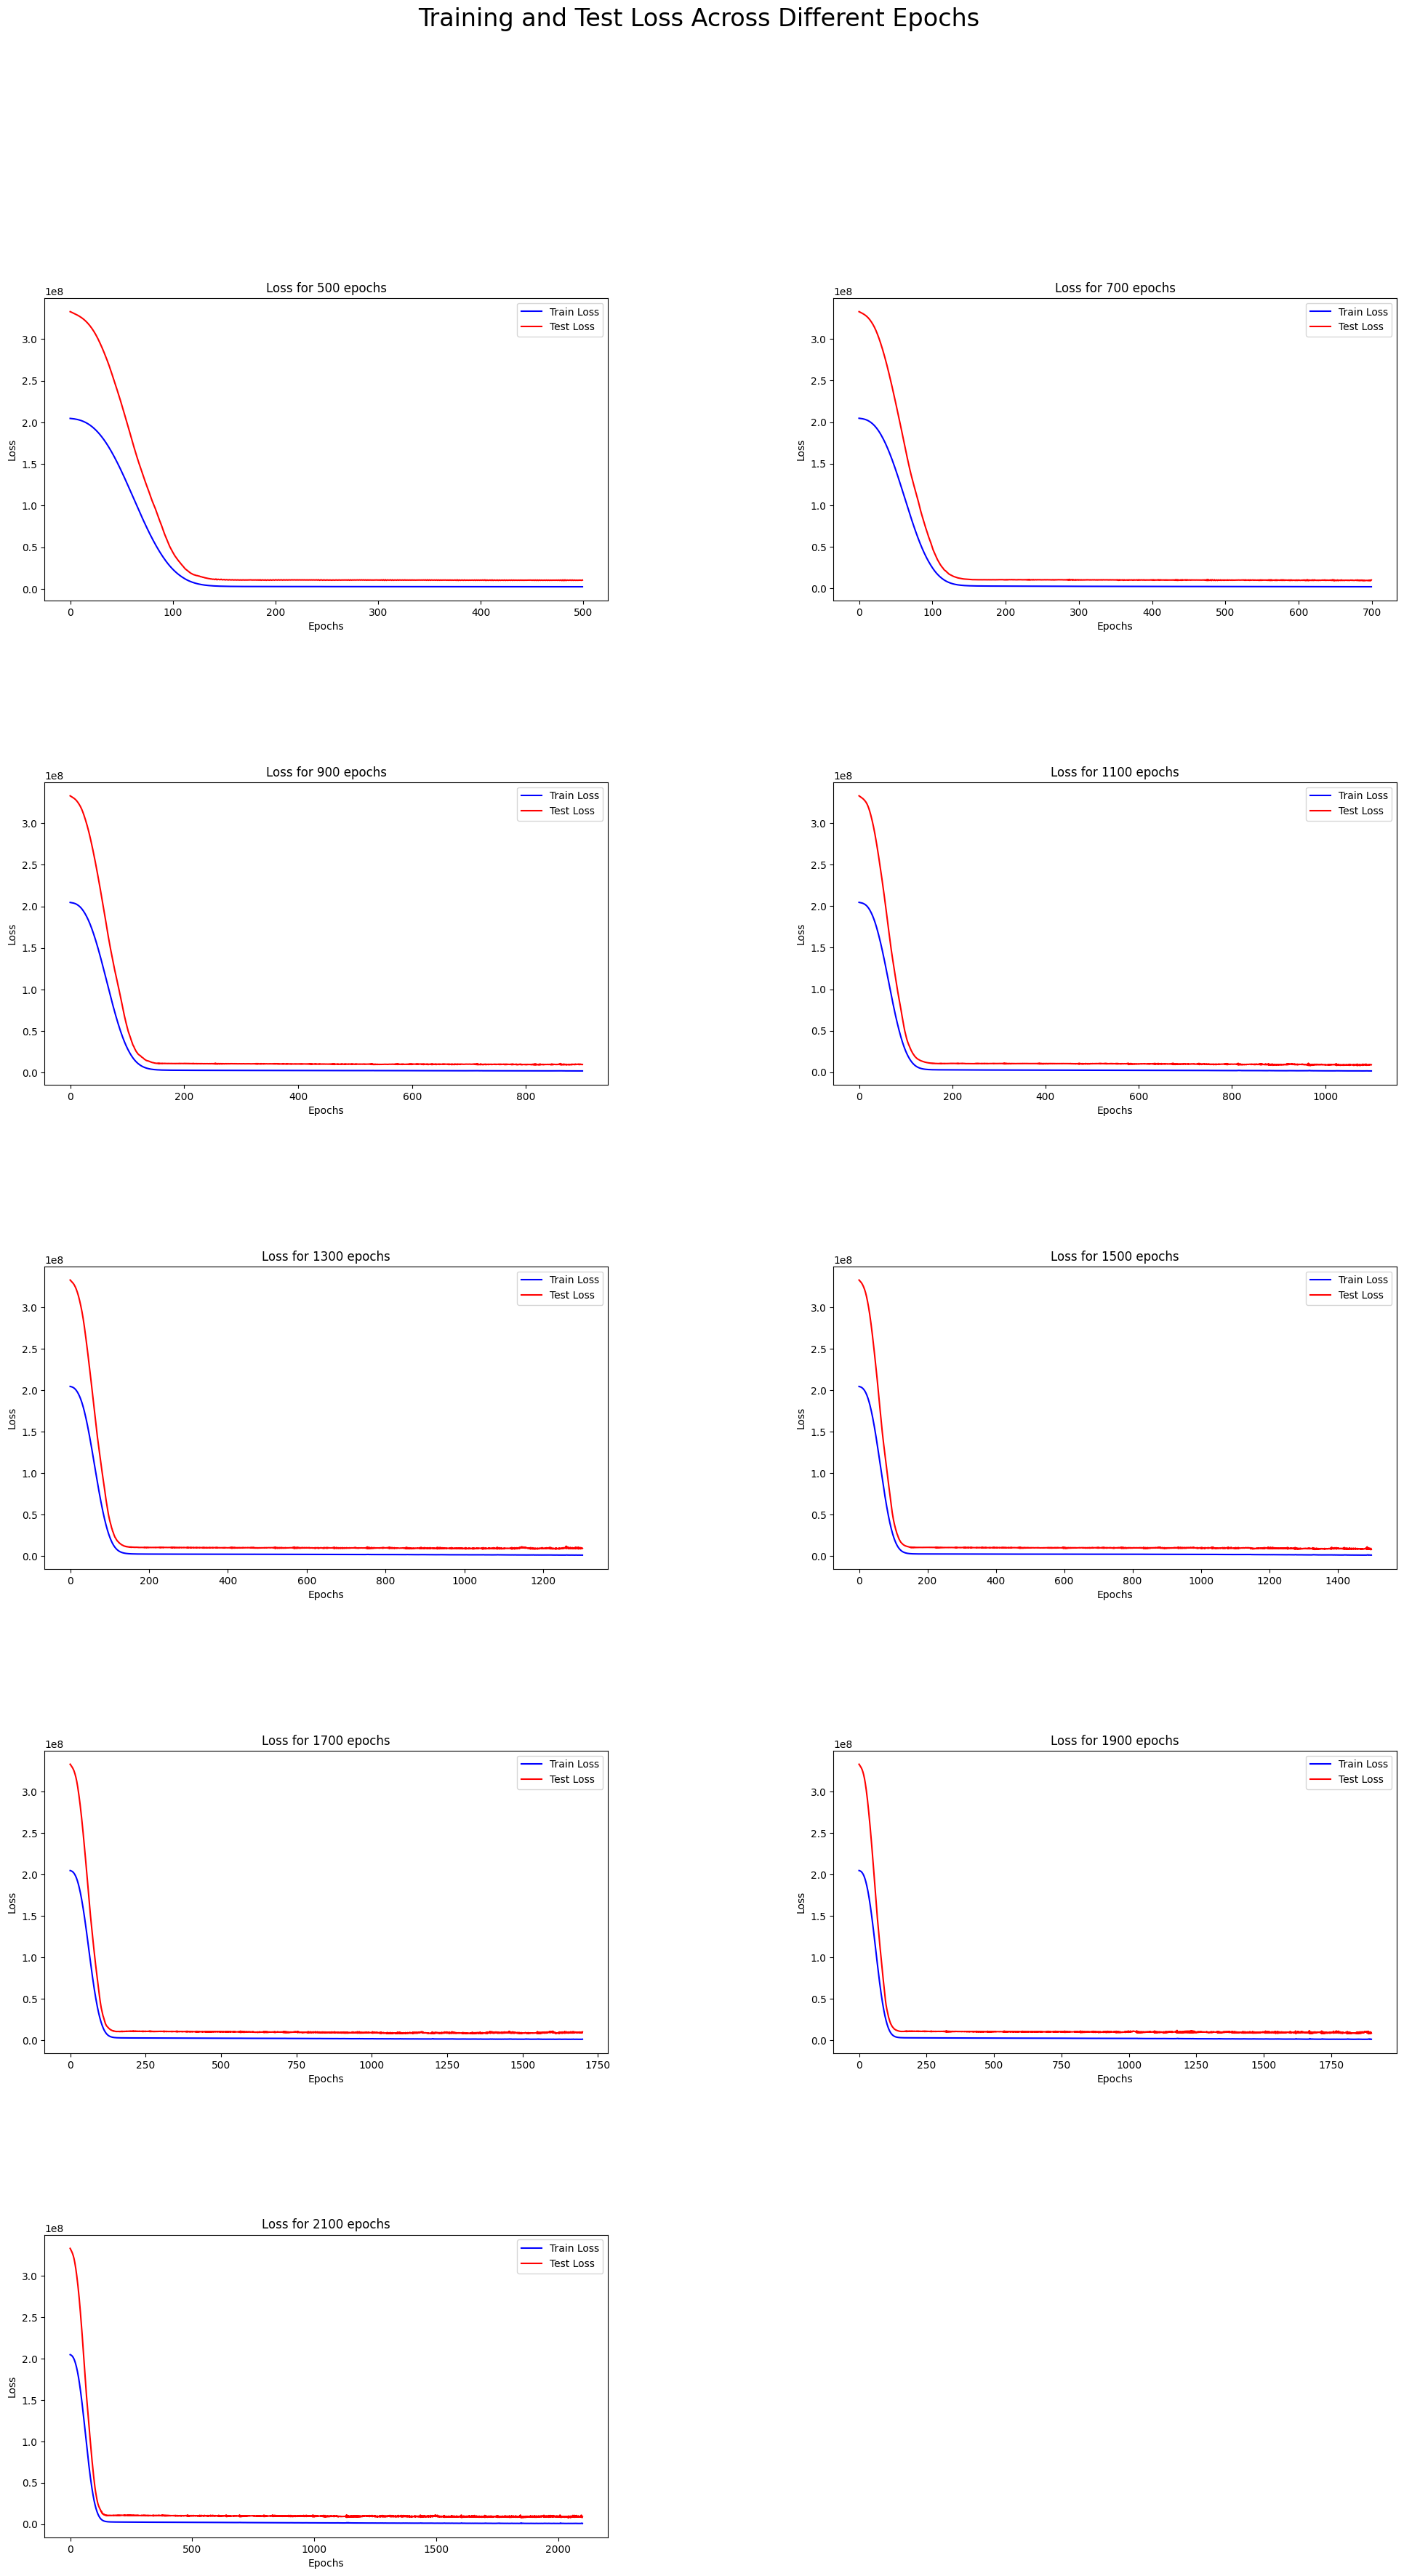

In [37]:
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

fig = plt.figure(figsize=(24, 40))
outer_grid = GridSpec(5, 2, figure=fig, wspace=0.4, hspace=0.6)

predictions = []

for i, num_epochs in enumerate(np.arange(500, 2101, 200)):

    model = Regress_NNv3(input_size = 27)

    criterion = nn.MSELoss()

    optimizer = torch.optim.AdamW(model.parameters(), lr = 0.1)
    # Тренировка модели и предсказание
    train_loss, test_loss = train(model=model, train_loader=train_loader, optimizer=optimizer, criterion=criterion, num_epochs=num_epochs)
    preds = predict(model, test_loader)

    predictions.append(preds)

    # Вычисляем метрики
    r2 = r2_score(ytest.numpy(), preds[0].numpy())
    mse = mean_squared_error(ytest.numpy(), preds[0].numpy()) ** 0.5
    print(f'Epochs: {num_epochs} | R^2 score: {r2}, MSE: {mse}')

    ax = fig.add_subplot(outer_grid[i])
    ax.plot(np.arange(0, num_epochs), train_loss, color='b', label='Train Loss')
    ax.plot(np.arange(0, num_epochs), test_loss, color='r', label='Test Loss')

    ax.legend()
    ax.set_title(f'Loss for {num_epochs} epochs')
    ax.set_xlabel('Epochs')
    ax.set_ylabel('Loss')

plt.suptitle('Training and Test Loss Across Different Epochs', fontsize=24)
plt.show()

Видим, что в данной архитектуре лосс наиболее стабильно снижается. И качество выше. Возьмем лучшее количество эпох в качестве финального предикта

In [42]:
# Запишем лучшие предсказания

best_predict = predictions[5][0].numpy().flatten()

r2 = r2_score(ytest.numpy(), best_predict)
mse = mean_squared_error(ytest.numpy(), best_predict) ** 0.5

print(f'R2 : {r2}, MSE: {mse}')

R2 : 0.924727737903595, MSE: 2850.0663150179507
